In [1]:
import tensorflow as tf
import os
import time
import datetime
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_WIDTH = 512
IMG_HEIGHT = 660

In [3]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    return image

def random_jitter(image):
    image = tf.image.resize(image, [512, 512],method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def load_image(image_file):
    image = load(image_file)
    image = random_jitter(image)
    image = normalize(image)

    return image

def create_dataset(path_to_images,batch_size):
    dataset = tf.data.Dataset.list_files(path_to_images,shuffle=False)
    dataset = dataset.map(load_image, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch_size)

    return dataset

In [4]:
path_to_folder = 'D:\\three dimensional reconstruction\\cyclegan_data'

In [5]:
dataset_2d= create_dataset(os.path.join(path_to_folder, '2d/*.jpg'),batch_size=1)

In [6]:
# dataset_1 = tf.data.Dataset.list_files(os.path.join(path_to_folder, '2d/*.jpg'),shuffle=False)
# for batch in dataset_1 :
#     print(batch)

In [7]:
# dataset_2 = tf.data.Dataset.list_files(os.path.join(path_to_folder, '3d/*.jpg'),shuffle=False)
# for batch in dataset_2:
#     print(batch)

In [8]:
len(dataset_2d)

13175

In [9]:
dataset_3d= create_dataset(os.path.join(path_to_folder, '3d/*.jpg'),batch_size=1)

In [10]:
len(dataset_3d)

13175

In [11]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)

        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

In [12]:
def upsample(filters, size, norm_type='instancenorm', apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [13]:
def downsample(filters, size, norm_type='instancenorm', apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_norm:
        if norm_type.lower() == 'batchnorm':
            result.add(tf.keras.layers.BatchNormalization())
        elif norm_type.lower() == 'instancenorm':
            result.add(InstanceNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [14]:
def generator(output_channels, norm_type='instancenorm'):
    down_stack = [
      downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
      downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
      downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
      downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
      downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
      downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
      downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
      downsample(512, 4, norm_type),  # (bs, 1, 1, 512)
    ]

    up_stack = [
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
      upsample(512, 4, norm_type),  # (bs, 16, 16, 1024)
      upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
      upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
      upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

    concat = tf.keras.layers.Concatenate()

    inputs = tf.keras.layers.Input(shape=[None, None, 3])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [15]:
def discriminator(norm_type='instancenorm', target=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
    x = inp

    if target:
        tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
        x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    if norm_type.lower() == 'batchnorm':
        norm1 = tf.keras.layers.BatchNormalization()(conv)
    elif norm_type.lower() == 'instancenorm':
        norm1 = InstanceNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    if target:
        return tf.keras.Model(inputs=[inp, tar], outputs=last)
    else:
        return tf.keras.Model(inputs=inp, outputs=last)

In [16]:
OUTPUT_CHANNELS = 3

generator_g = generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = discriminator(norm_type='instancenorm', target=False)
discriminator_y = discriminator(norm_type='instancenorm', target=False)

In [17]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

In [19]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [20]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [21]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [22]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [23]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果存在检查点，恢复最新版本检查点
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [24]:
log_dir="D:\\three dimensional reconstruction\\log_dir"
summary_writer = tf.summary.create_file_writer(log_dir) 

In [25]:
EPOCHS = 5

In [26]:
def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize=(12, 12))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # 获取范围在 [0, 1] 之间的像素值以绘制它。
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [27]:
@tf.function
def train_step(real_x, real_y):
    # persistent 设置为 Ture，因为 GradientTape 被多次应用于计算梯度。
    with tf.GradientTape(persistent=True) as tape:
        # 生成器 G 转换 X -> Y。
        # 生成器 F 转换 Y -> X。

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x 和 same_y 用于一致性损失。
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # 计算损失。
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # 总生成器损失 = 对抗性损失 + 循环损失。
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    
    with summary_writer.as_default():  # 将loss写入TensorBoard
        tf.summary.scalar('gen_g_loss', gen_g_loss, step=epoch)
        tf.summary.scalar('gen_f_loss', gen_f_loss, step=epoch)
        tf.summary.scalar('total_cycle_loss', total_cycle_loss, step=epoch)
        tf.summary.scalar('total_gen_g_loss', total_gen_g_loss, step=epoch)
        tf.summary.scalar('total_gen_f_loss', total_gen_f_loss, step=epoch)
        tf.summary.scalar('disc_x_loss', disc_x_loss, step=epoch)
        tf.summary.scalar('disc_y_loss', disc_y_loss, step=epoch)
    
    # 计算生成器和判别器损失。
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

    # 将梯度应用于优化器。
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [39]:
sample_2d = next(iter(dataset_2d))
sample_3d = next(iter(dataset_3d))

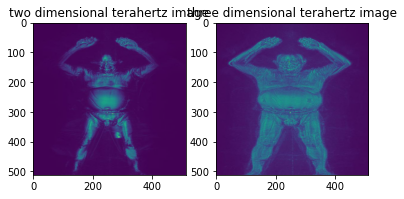

In [29]:
plt.subplot(121)
plt.title('two dimensional terahertz image')
plt.imshow(sample_2d[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('three dimensional terahertz image')
plt.imshow(sample_3d[0] * 0.5 + 0.5)

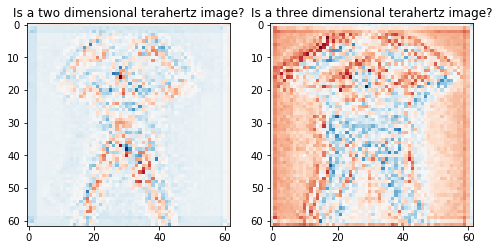

In [30]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a two dimensional terahertz image?')
plt.imshow(discriminator_y(sample_2d)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a three dimensional terahertz image?')
plt.imshow(discriminator_x(sample_3d)[0, ..., -1], cmap='RdBu_r')

plt.show()

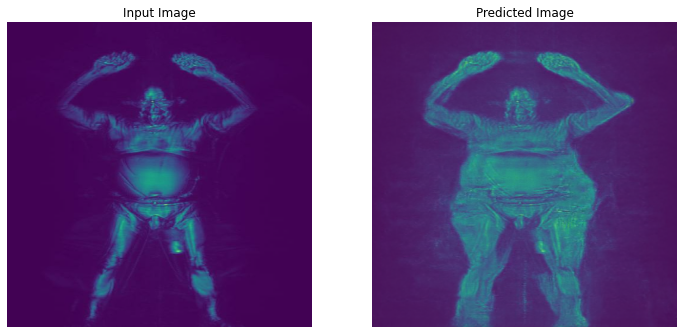

Saving checkpoint for epoch 5 at ./checkpoints/train\ckpt-5
Time taken for epoch 5 is 3953.815843105316 sec



In [31]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((dataset_2d, dataset_3d)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print ('.', end='')
        n+=1
    clear_output(wait=True)
    # 使用一致的图像（sample_horse），以便模型的进度清晰可见。
    generate_images(generator_g, sample_2d)

    if (epoch + 1) % 1 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))
    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))